In [2]:
import os.path

from absl import app
from absl import flags
from absl import logging

import numpy as np
import tensorflow as tf
import uncertainty_baselines as ub
import uncertainty_metrics as um

from resnet20 import create_model as resnet20_multihead
#from resnet20 import train_model as resnet20_multihead_train
from resnet20 import load_model as resnet20_multihead_load
from resnet20 import configure_model as resnet20_multihead_configure
from resnet20 import calibrate_model_nonlin

from func import load_datasets_basic, load_datasets_corrupted, add_dataset_flags
from func import AttrDict

from metrics import rel_diag,ece,brier, ECE, BrierScore, NLL
from metrics import comp_metrics, quartiles

from func import one_vs_all_loss_fn
from func import AttrDict, load_flags, save_flags

In [52]:
FLAGS = load_flags('FLAGS.json')

In [53]:
FLAGS

{'seed': 1337,
 'output_dir': 'outdir',
 'optimizer': 'sgd',
 'learning_rate': 0.1,
 'weight_decay': 0.0001,
 'model_file': 'outdir/model.ckpt-250',
 'dataset': 'cifar10',
 'certainty_variant': 'partial',
 'activation': 'relu',
 'batch_size': 128,
 'eval_batch_size': 100,
 'validation_percent': 0.1,
 'eval_frequency': 100,
 'num_bins': 15,
 'epochs': 250,
 'augment_train': True,
 'model_variant': '1vsall',
 'calibration_variant': 'nonlin',
 'which_output': 'certs',
 'which_dataset': 'val',
 'cal_dict': {'epochs': 10000,
  'bins': 1000,
  'basis_type': 'uniform',
  'basis_params': [-20, 20, 100]}}

In [166]:
FLAGS.output_dir = 'vanilla_relu'
FLAGS.model_file = 'vanilla_relu/model.ckpt-250'
FLAGS.activation = 'relu'
FLAGS.model_variant = 'vanilla'
FLAGS.which_output = 'probs'


In [21]:
FLAGS.output_dir = '1vsall_relu'
FLAGS.model_file = '1vsall_relu/model.ckpt-250'
FLAGS.activation = 'relu'

In [21]:
FLAGS.output_dir = '1vsall_sin'
FLAGS.model_file = '1vsall_sin/model.ckpt-250'
FLAGS.activation = 'sin'

<h2>training</h2>

In [48]:
logging.info('Multihead CIFAR-10 ResNet-20 train')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

tensorboard_callback, optimizer, loss_funcs, metrics = resnet20_multihead_configure(FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                            l2_weight=FLAGS.weight_decay,
                            certainty_variant=FLAGS.certainty_variant,
                            activation_type=FLAGS.activation
                            )

model.compile(optimizer=optimizer,
              loss=loss_funcs,
              metrics=metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
history = model.fit(train_dataset,
                    #batch_size=FLAGS.batch_size,
                    epochs=FLAGS.epochs,
                    steps_per_epoch=FLAGS.steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=FLAGS.validation_steps,
                    validation_freq=FLAGS.eval_frequency,
                    callbacks=[tensorboard_callback],
                    shuffle=False)

In [ ]:
model_dir = os.path.join(FLAGS.output_dir, 'model.ckpt-{}'.format(FLAGS.epochs))
logging.info('Saving model to '+model_dir)
model.save_weights(model_dir)

# corrupt

In [24]:
FLAGS = load_flags('FLAGS.json')

In [6]:
FLAGS.output_dir = 'vanilla_relu'
FLAGS.model_file = 'vanilla_relu/model.ckpt-250'
FLAGS.activation = 'relu'
FLAGS.model_variant = 'vanilla'
FLAGS.which_output = 'probs'
FLAGS.cal_dict = {'epochs': 10000, 'bins': 1000, 'basis_type': 'uniform', 'basis_params': [-20, 20, 100]}

In [25]:
FLAGS.output_dir = 'vanilla_sin'
FLAGS.model_file = 'vanilla_sin/model.ckpt-250'
FLAGS.activation = 'sin'
FLAGS.model_variant = 'vanilla'
FLAGS.which_output = 'probs'
FLAGS.cal_dict = {'epochs': 10000, 'bins': 1000, 'basis_type': 'uniform', 'basis_params': [-20, 20, 100]}

In [224]:
FLAGS.output_dir = '1vsall_sin'
FLAGS.model_file = '1vsall_sin/model.ckpt-250'
FLAGS.activation = 'sin'
FLAGS.model_variant = '1vsall'
FLAGS.which_output = 'probs'
FLAGS.certainty_variant = 'total'
FLAGS.cal_dict = {'epochs': 10000, 'bins': 4000, 'basis_type': 'uniform', 'basis_params': [-20, 20, 100]}

In [219]:
FLAGS.output_dir = '1vsall_relu'
FLAGS.model_file = '1vsall_relu/model.ckpt-250'
FLAGS.activation = 'relu'
FLAGS.model_variant = '1vsall'
FLAGS.which_output = 'probs'
FLAGS.certainty_variant = 'total'
FLAGS.cal_dict = {'epochs': 10000, 'bins': 4000, 'basis_type': 'uniform', 'basis_params': [-20, 20, 100]}







In [26]:
FLAGS

{'seed': 1337,
 'output_dir': 'vanilla_sin',
 'optimizer': 'sgd',
 'learning_rate': 0.1,
 'weight_decay': 0.0001,
 'model_file': 'vanilla_sin/model.ckpt-250',
 'dataset': 'cifar10',
 'certainty_variant': 'partial',
 'activation': 'sin',
 'batch_size': 128,
 'eval_batch_size': 100,
 'validation_percent': 0.1,
 'eval_frequency': 100,
 'num_bins': 15,
 'epochs': 250,
 'augment_train': True,
 'model_variant': 'vanilla',
 'calibration_variant': 'nonlin',
 'which_output': 'probs',
 'which_dataset': 'val',
 'cal_dict': {'epochs': 10000,
  'bins': 1000,
  'basis_type': 'uniform',
  'basis_params': [-20, 20, 100]}}

In [27]:
logging.info('Multihead CIFAR-10 ResNet-20 train')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

tensorboard_callback, optimizer, loss_funcs, metrics = resnet20_multihead_configure(FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                            l2_weight=FLAGS.weight_decay,
                            certainty_variant=FLAGS.certainty_variant,
                            activation_type=FLAGS.activation,
                            model_variant=FLAGS.model_variant
                          )

model.compile(optimizer=optimizer,
              loss=loss_funcs,
              metrics=metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [28]:
resnet20_multihead_load(model,FLAGS)

In [29]:
model.evaluate(train_dataset)

352/352 [==============================] - 29s 83ms/step - loss: 0.1470 - logits_loss: 0.0287 - certs_ece: 0.0067 - probs_sparse_categorical_accuracy: 0.9915 - probs_lr: 1.0000e-03


[0.1470339149236679,
 0.028713958337903023,
 0.0066540297120809555,
 0.9914994835853577,
 0.0009999972535297275]

In [30]:
model.evaluate(val_dataset)

50/50 [==============================] - 1s 11ms/step - loss: 0.5320 - logits_loss: 0.4137 - certs_ece: 0.0601 - probs_sparse_categorical_accuracy: 0.9030 - probs_lr: 1.0000e-03


[0.5320317149162292,
 0.41371187567710876,
 0.060081999748945236,
 0.902999997138977,
 0.0009999994654208422]

In [31]:
model.evaluate(test_dataset)

100/100 [==============================] - 1s 9ms/step - loss: 0.5326 - logits_loss: 0.4143 - certs_ece: 0.0617 - probs_sparse_categorical_accuracy: 0.8988 - probs_lr: 0.0010


[0.5326200127601624,
 0.41429999470710754,
 0.061678189784288406,
 0.8988000154495239,
 0.001000000280328095]

In [32]:
cal_model, W1 = calibrate_model_nonlin(model=model,
                                      dataset=val_dataset,
                                      FLAGS=FLAGS,
                                      output=FLAGS.which_output,
                                      **FLAGS.cal_dict
                                     )

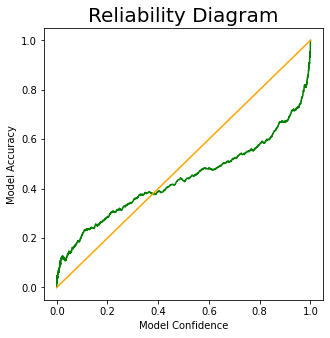

In [33]:
rel_diag(model,
                 val_dataset,
                 FLAGS,
                 output=FLAGS.which_output,
                 savefig=False)

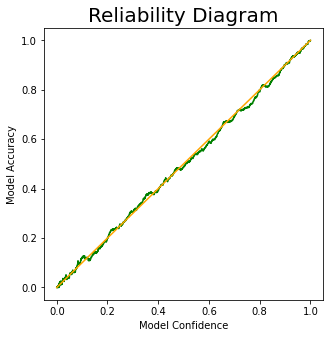

In [34]:
rel_diag(cal_model,
                 val_dataset,
                 FLAGS,
                 output=FLAGS.which_output+'_cal',
                 savefig=False)

In [35]:
_, test_datasets_corrupt = load_datasets_corrupted(FLAGS)

In [36]:
metrics = {'ece':ECE(num_bins=FLAGS.num_bins, name='ece'),
                   'brier':BrierScore(),
                   'nll':NLL()}
        
results, quartiles = comp_metrics(model=model,
                                   datasets={'clean':test_datasets_corrupt['clean']},
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   output='certs',
                                   return_quartiles=True)

#save batch ECE results
results['summary_metrics'] = list(metrics.keys())

results

{'clean': [0.061485905200242996, 0.1624324768781662, 0.412942498922348],
 'summary_metrics': ['ece', 'brier', 'nll']}

In [37]:
metrics = {'ece':ECE(num_bins=FLAGS.num_bins, name='ece'),
                   'brier':BrierScore(),
                   'nll':NLL()}
        
results, quartiles = comp_metrics(model=cal_model,
                                   datasets={'clean':test_datasets_corrupt['clean']},
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   output=FLAGS.which_output+'_cal',
                                   return_quartiles=True)

results['summary_metrics'] = list(metrics.keys())
results

{'clean': [0.005275691859424114, 0.14850309491157532, 0.30498620867729187],
 'summary_metrics': ['ece', 'brier', 'nll']}

In [38]:
metrics = {'ece':ECE(num_bins=FLAGS.num_bins, name='ece'),
                   'brier':BrierScore(),
                   'nll':NLL()}
        
results, quartiles = comp_metrics(model=model,
                                   datasets=test_datasets_corrupt,
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   output=FLAGS.which_output,
                                   return_quartiles=True)

#save batch ECE results
results['summary_quart_25th'] = quartiles[0]
results['summary_quart_50th'] = quartiles[1]
results['summary_quart_75th'] = quartiles[2]
results['summary_metrics'] = list(metrics.keys())

In [39]:
quartiles

([0.08234741538763046, 0.21642039343714714, 0.5669727325439453],
 [0.13815616816282272, 0.34517449140548706, 0.9809294044971466],
 [0.2119305655360222, 0.5152214616537094, 1.5048152804374695])

In [40]:

metrics = {'ece':ECE(num_bins=FLAGS.num_bins, name='ece'),
                   'brier':BrierScore(),
                   'nll':NLL()}
        
results, quartiles = comp_metrics(model=cal_model,
                                   datasets=test_datasets_corrupt,
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   output=FLAGS.which_output+'_cal',
                                   return_quartiles=True)

#save batch ECE results
results['summary_quart_25th'] = quartiles[0]
results['summary_quart_50th'] = quartiles[1]
results['summary_quart_75th'] = quartiles[2]
results['summary_metrics'] = list(metrics.keys())

In [41]:
quartiles

([0.015108963707461953, 0.19662870466709137, 0.4071059823036194],
 [0.05038418248295784, 0.3085743337869644, 0.6510652005672455],
 [0.10291256755590439, 0.4524870812892914, 0.9667367488145828])

<h1>accs</h1>

In [169]:
FLAGS = load_flags('FLAGS.json')

In [170]:
FLAGS

{'seed': 1337,
 'output_dir': 'outdir',
 'optimizer': 'sgd',
 'learning_rate': 0.1,
 'weight_decay': 0.0001,
 'model_file': 'outdir/model.ckpt-250',
 'dataset': 'cifar10',
 'certainty_variant': 'partial',
 'activation': 'relu',
 'batch_size': 128,
 'eval_batch_size': 100,
 'validation_percent': 0.1,
 'eval_frequency': 100,
 'num_bins': 15,
 'epochs': 250,
 'augment_train': True,
 'model_variant': '1vsall',
 'calibration_variant': 'nonlin',
 'which_output': 'certs',
 'which_dataset': 'val',
 'cal_dict': {'epochs': 10000,
  'bins': 1000,
  'basis_type': 'uniform',
  'basis_params': [-20, 20, 100]}}

In [171]:
FLAGS.output_dir = '1vsall_relu'
FLAGS.model_file = '1vsall_relu/model.ckpt-250'
FLAGS.activation = 'relu'

In [76]:
FLAGS.output_dir = '1vsall_sin'
FLAGS.model_file = '1vsall_sin/model.ckpt-250'
FLAGS.activation = 'sin'

In [173]:
loss_funcs = {'logits':one_vs_all_loss_fn(from_logits=True),
                  'probs':None,
                  'certs':None,
                  'logits_from_certs':None}
metrics = {'logits':[tf.keras.metrics.SparseCategoricalAccuracy()],
           'probs':[um.ExpectedCalibrationError(num_bins=FLAGS.num_bins, name='ece'),
                   tf.keras.metrics.SparseCategoricalAccuracy()],
           'certs':[um.ExpectedCalibrationError(num_bins=FLAGS.num_bins,name='ece'),
                    tf.keras.metrics.SparseCategoricalAccuracy()],
           'logits_from_certs':[tf.keras.metrics.SparseCategoricalAccuracy()]}

In [174]:
logging.info('Multihead CIFAR-10 ResNet-20 train')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

tensorboard_callback, optimizer, loss_funcs, metrics = resnet20_multihead_configure(FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                            l2_weight=FLAGS.weight_decay,
                            certainty_variant=FLAGS.certainty_variant,
                            activation_type=FLAGS.activation
                            )

model.compile(optimizer=optimizer,
              loss=loss_funcs,
              metrics=metrics)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [175]:
resnet20_multihead_load(model,FLAGS)

In [176]:
model.evaluate(test_dataset)

100/100 [==============================] - 1s 9ms/step - loss: 0.9767 - logits_loss: 0.7838 - certs_ece: 0.0462 - certs_sparse_categorical_accuracy: 0.9063 - logits_sparse_categorical_accuracy: 0.9063 - logits_from_certs_sparse_categorical_accuracy: 0.9063 - probs_ece: 0.0569 - probs_sparse_categorical_accuracy: 0.9063


[0.9767186641693115,
 0.7837676405906677,
 0.04619608819484711,
 0.9063000082969666,
 0.9063000082969666,
 0.9063000082969666,
 0.05687550827860832,
 0.9063000082969666]

In [177]:
cal_model, _ = calibrate_model_nonlin(model=model,
                                      dataset=test_dataset,
                                      FLAGS=FLAGS,
                                      output=FLAGS.which_output,
                                      **FLAGS.cal_dict
                                     )

In [178]:
i=0
m = tf.keras.metrics.Accuracy()
m.reset_states()
for x,y in test_dataset:
    
    if i>FLAGS.test_steps:
        break
    m.update_state(tf.cast(tf.argmax(cal_model(x)['certs_cal'],axis=1),dtype=tf.int32),y)
    i+=1
m.result().numpy()

0.9063

<h2>calibration + reliability diagrams</h2>

In [3]:
logging.info('Multihead CIFAR-10 ResNet-20 calibrate')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [24]:

resnet20_multihead_load(model,FLAGS)

In [25]:
dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [26]:
model.evaluate(test_dataset)

100/100 [==============================] - 1s 7ms/step - loss: 0.5475 - logits_loss: 0.4293 - certs_ece: 0.8641 - probs_sparse_categorical_accuracy: 0.8818 - probs_lr: 0.0010


[0.547511875629425,
 0.42934179306030273,
 0.8640589714050293,
 0.8817999958992004,
 0.001000000280328095]

In [5]:
cal_model_iso, _ = calibrate_model_isotonic(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               output='certs',
                                               bins=1000,
                                              )

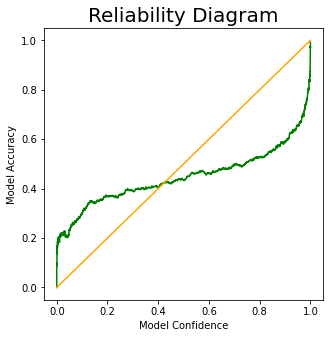

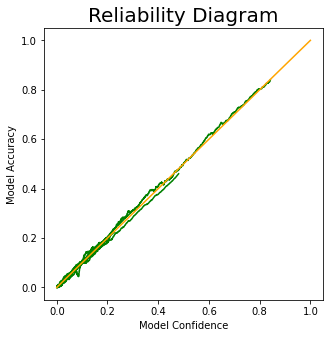

In [6]:
rel_diag(model,val_dataset,FLAGS,output='certs')
rel_diag(cal_model_iso,val_dataset,FLAGS,output='certs_cal')


In [7]:
cal_model_temp, _ = calibrate_model_temp(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               output='logits_from_certs',
                                               epochs=20,
                                              )

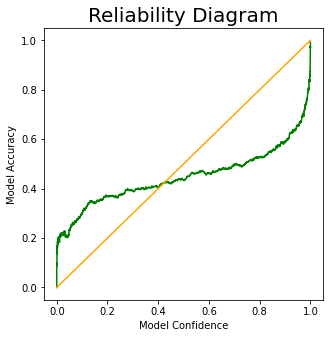

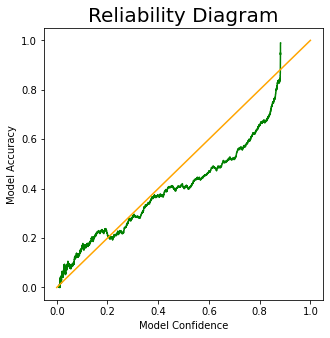

In [8]:
rel_diag(model,val_dataset,FLAGS,output='certs')
rel_diag(cal_model_temp,val_dataset,FLAGS,output='logits_from_certs_cal')


In [4]:
cal_model_nonlin, _ = calibrate_model_nonlin(model,
                                       val_dataset,
                                       FLAGS=FLAGS,
                                       output='certs',
                                       epochs=10000,
                                       bins=1000,
                                       basis_type='list',
                                       basis_list=np.linspace(-20,20,100)
                                      )

In [7]:
cal_model_nonlin, _ = calibrate_model_nonlin(model,
                                       val_dataset,
                                       FLAGS=FLAGS,
                                       output='certs',
                                       epochs=10000,
                                       bins=1000,
                                       basis_type='uniform',
                                       basis_params=[-20,20,100]
                                      )

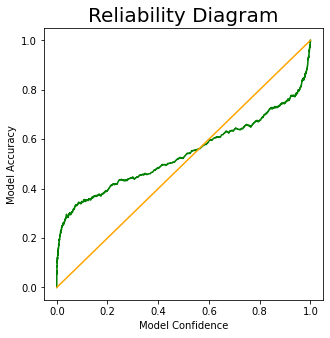

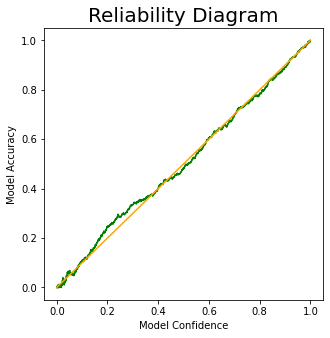

In [8]:
rel_diag(model,val_dataset,FLAGS,output='certs')
rel_diag(cal_model_nonlin,val_dataset,FLAGS,output='certs_cal')


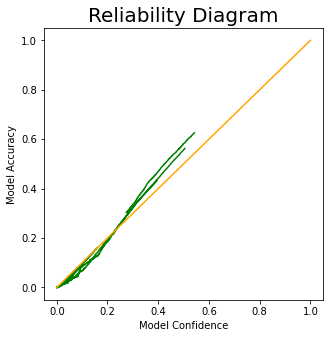

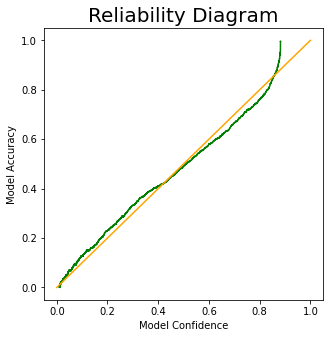

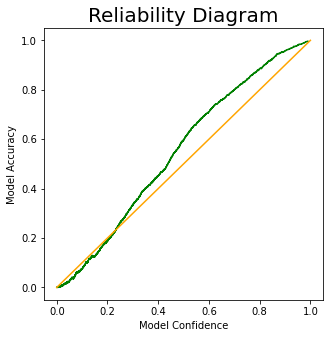

In [13]:
rel_diag(cal_model_iso,train_dataset,FLAGS,output='certs_cal')
rel_diag(cal_model_temp,train_dataset,FLAGS,output='logits_from_certs_cal')
rel_diag(cal_model_nonlin,train_dataset,FLAGS,output='certs_cal')

<h2>single ECE</h2>

In [8]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [9]:
logging.info('Multihead CIFAR-10 ResNet-20 ECE')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [10]:
cal_model_iso, _ = calibrate_model_isotonic(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               output='certs', #or 'probs'
                                              )

In [11]:
ece(cal_model_iso,val_dataset,FLAGS,output='certs_cal')

0.013388589024543762

<h2>batch ECE for corrupted CIFAR10</h2>

In [2]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [3]:
logging.info('Multihead CIFAR-10 ResNet-20 batch ECE')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
_, test_datasets_corrupt = load_datasets_corrupted(FLAGS)
logging.info(f'Loaded corrupted test_datasets...{len(test_datasets_corrupt)-1}')
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
#test_datasets_corrupt subset for faster evaluation
subset = {'clean','snow_1','fog_4','elastic_3'}
tdc_subset = {k: test_datasets_corrupt[k] for k in test_datasets_corrupt.keys() if k in subset}

In [4]:
metrics = {'ece':ECE(num_bins=FLAGS.num_bins, name='ece')}

results, quartiles = comp_metrics(model=model,
                                   datasets=test_datasets_corrupt,
                                   metrics=metrics,
                                   FLAGS=FLAGS,
                                   output='certs',
                                   return_quartiles=True)

In [5]:
quartiles

(0.17085923627018929, 0.21984294056892395, 0.26416806876659393)

<h2>single BrierScore</h2>

In [2]:
FLAGS = AttrDict({'seed':1337,
                  'output_dir':'dir1_relu',
                  'optimizer': 'adam',
                  'learning_rate':0.01,
                  'weight_decay':None,
                  'model_file':'dir1_relu/model.ckpt-60',
                  'dataset':'cifar10',
                  'certainty_variant':'partial',
                  'activation':'relu',
                  'batch_size':128,
                  'eval_batch_size':100,
                  'validation_percent':0.1,
                  'eval_frequency':100,
                  'num_bins':15,
                  'epochs':60
                 })

In [3]:
logging.info('Multihead CIFAR-10 ResNet-20 Brier')

tf.random.set_seed(FLAGS.seed)
np.random.seed(FLAGS.seed)

dataset_builder,train_dataset,val_dataset,test_dataset = load_datasets_basic(FLAGS)
FLAGS = add_dataset_flags(dataset_builder,FLAGS)

model = resnet20_multihead(batch_size=FLAGS.batch_size,
                           l2_weight=None,
                           certainty_variant=FLAGS.certainty_variant,
                           activation_type=FLAGS.activation)

resnet20_multihead_load(model,FLAGS)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [4]:
cal_model_iso, _ = calibrate_model_isotonic(model,
                                               val_dataset,
                                               FLAGS=FLAGS,
                                               output='certs', #or 'probs'
                                              )

In [5]:
brier(model,val_dataset,FLAGS,output='certs')

0.35519182682037354

In [6]:
brier(cal_model_iso,val_dataset,FLAGS,output='certs_cal')

0.3010418713092804

# windows and bins

In [154]:
FLAGS.no_classes = 10
FLAGS.steps_per_epoch = 351
dataset = test_dataset
output = 'certs'
bins=30

In [164]:
# based on um.numpy.plot_diagram, um.numpy.reliability_diagram
def _extract_conf_acc(probs,labels,window_len=None,bins=None):

    probs = np.array(probs)
    labels = np.array(labels)
    labels_matrix = um.numpy.visualization.one_hot_encode(labels, probs.shape[1])

    # plot_diagram(probs.flatten(), labels_matrix.flatten(), y_axis))

    probs = probs.flatten()
    labels = labels_matrix.flatten()

    probs_labels = [(prob, labels[i]) for i, prob in enumerate(probs)]
    probs_labels = np.array(sorted(probs_labels, key=lambda x: x[0]))
    if window_len is None:
        window_len = int(len(labels)/100.)
#     if bins is None:
#         bins = int(len(labels))
    calibration_errors = []
    confidences = []
    accuracies = []
    # More interesting than length of the window (which is specific to this
    # window) is average distance between datapoints. This normalizes by dividing
    # by the window length.
    distances = []
    for i in range(len(probs_labels)-window_len):
        distances.append((
            probs_labels[i+window_len, 0] - probs_labels[i, 0])/float(window_len))
        # It's pretty sketchy to look for the 100 datapoints around this one.
        # They could be anywhere in the probability simplex. This introduces bias.
        mean_confidences = um.numpy.visualization.mean(probs_labels[i:i + window_len, 0])
        confidences.append(mean_confidences)
        class_accuracies = um.numpy.visualization.mean(probs_labels[i:i + window_len, 1])
        accuracies.append(class_accuracies)
        calibration_error = class_accuracies-mean_confidences
        calibration_errors.append(calibration_error)
    if bins>0:
        delta = int((len(probs_labels)-window_len)/bins)
        return confidences[::delta],accuracies[::delta]
    else:
        return confidences, accuracies

In [163]:
#number of classes
K = FLAGS.no_classes

labels = np.empty(0)
probs = np.empty((0,K))

for i,(x,y) in enumerate(dataset):
    if i>FLAGS.steps_per_epoch: break
    out = model(x)[output].numpy()
    labels = np.append(labels,y.numpy().astype('int32'))
    probs = np.concatenate((probs,out))

confidences, accuracies = _extract_conf_acc(probs=probs,labels=labels.astype('int32'),bins=bins)

1000


In [78]:
import matplotlib.pyplot as plt

In [156]:
len(confidences)

30

In [157]:
len(accuracies)

30

In [159]:
accuracies[-1]

0.995

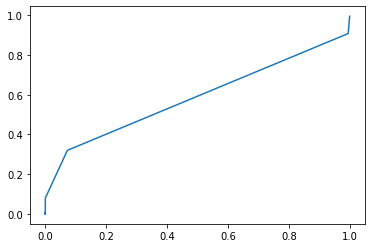

In [160]:

plt.plot(confidences,accuracies)